In [12]:
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator

#define utility functions

def simulate_qiskit(circuit, n_shots=1024) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """
    
    circuit.measure_all()
    simulator = QasmSimulator()

    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=n_shots)
    
    result = job.result()
    
    histogram = result.get_counts(compiled_circuit)
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates_qiskit(circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    #counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    #for i in range(2,20):
    #    assert counter[i]==0
        
    return 0

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)


In [8]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.99769319e-04 1.38408304e-03 2.07612457e-03 3.07574010e-03
  2.02998847e-03 9.22722030e-04 9.84236832e-04 1.27643214e-03
  2.81430219e-03 2.99884660e-03 1.49173395e-03 4.45982314e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.38254517e-04 1.92233756e-03 2.84505959e-03
  3.07574010e-03 2.93733180e-03 2.44521338e-03 2.70665129e-03
  3.58323722e-03 3.64475202e-03 3.92156863e-03 3.69088812e-03
  3.26028451e-03 2.52210688e-03 2.66051519e-03 3.09111880e-03
  2.93733180e-03 1.96847366e-03 1.53787005e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.45982314e-04 2.64513649e-03 2.62975779e-03 2.44521338e-03
  2.30

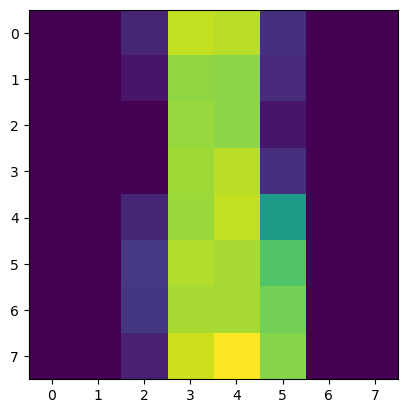

In [48]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

print(images[0])
print(np.max(images[0]))

import cv2
img = cv2.resize(images[1100], (8,8))
plt.imshow(img)

#print(images[1100])
#print(img)

In [72]:
#grade part1

import part1
from importlib import reload
reload(part1)

from part1 import *

n_shots = 10240
dataset = images

#n_qubits = np.ceil(2*np.log2(dataset.shape[1])).astype(int)

n=len(dataset)
mse=0
gatecount=0

for data in dataset[:2]:
    #encode image into circuit

    circuit = encode(data)

    print(circuit.count_ops())
    
    #simulate circuit
    #histogram=simulate(circuit)
    histogram = simulate_qiskit(circuit, n_shots=n_shots)
    
    #count the number of 2-qubit gates
    #gatecount+=count_gates(circuit)[2]
    
    #reconstruct the image
    image_re = decode(histogram)

    #calculate mse
    mse+=image_mse(data,image_re)
    print(mse)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

OrderedDict([('cx', 10368), ('u3', 3334), ('u', 3213), ('u2', 5)])
1.2453027091511898e-06
OrderedDict([('cx', 11008), ('u3', 3648), ('u', 3529), ('u2', 5)])
2.553032278157653e-06
0.9999974469677219


In [5]:
#grade part 2

#load classifier circuit
with open('part2.pickle', 'rb') as f:
    classifier=pickle.load(f)
    
score=0


for data in dataset:
    #encode image into circuit
    circuit=encode_cirq(data['image'])
    
    #append with classifier circuit
    
    circuit.append(classifier)
    
    #simulate circuit
    histogram=simulate(circuit)
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
        
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

AttributeError: 'NoneType' object has no attribute 'append'

# test

In [ ]:
#grade part1

import part1
from importlib import reload
reload(part1)

from part1 import *

n_shots = 102400

# dataset = images
# print(dataset)

#n_qubits = np.ceil(2*np.log2(dataset.shape[1])).astype(int)
n_qubits = 2

n=len(dataset)
mse=0
gatecount=0

circs=[]

for data in dataset[:2]:
    # encode image into circuit
    # circuit=encode_cirq(data['image'])

    #data_input = data.flatten()
    data_input = np.array(data['image']).flatten()

    orig_color_scale = np.sum(data_input)

    circuit = encode_qiskit(data_input, n_qubits=n_qubits)

    #print(circuit.draw())
    
    #simulate circuit
    #histogram=simulate(circuit)
    histogram = simulate_qiskit(circuit, n_qubits=n_qubits, n_shots=n_shots)

    print(histogram)

    # recover color
    recovered_image_cos = np.zeros(len(data_input))
    recovered_image_sin = np.zeros(len(data_input))

    for key in histogram:
        idx_bin = key[1:]
        idx = int(idx_bin,2)
        if key[0] == '0':
            recovered_image_cos[idx] = histogram[key]
        else:
            recovered_image_sin[idx] = histogram[key]

    print(np.array(data['image']))
    prob = recovered_image_sin/(recovered_image_sin+recovered_image_cos)
    print(np.sqrt(prob)*510/np.pi)

    #recovered_image = color_conversion(recovered_image/n_shots)
    #print(recovered_image.reshape(2,2))
    
    #count the number of 2-qubit gates
    #gatecount+=count_gates(circuit)[2]
    
    #reconstruct the image
    image_re = decode(histogram)
    
    #calculate mse
    #mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))